In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pickle
from scipy.interpolate import griddata
import csv

%run -i storm_coords.py

In [2]:
# Load the contour file
contour_file = 'contour15sp.csv'
df = pd.read_csv( contour_file )
contour15sp = np.column_stack( (df['contour15s_lon'], df['contour15s_lat']) )
normals15sp = np.column_stack( (df['normals15_x'], df['normals15_y']) )
df

,contour15s_lon,contour15s_lat,contour15s_x,contour15s_y,normals15_x,normals15_y
0,-90.294734,28.974981,-407646.233968,3.241079e+06,-0.334033,0.942561
1,-90.276154,28.982270,-405759.053321,3.241748e+06,-0.332962,0.942940
2,-90.257552,28.989520,-403870.358218,3.242413e+06,-0.330494,0.943808
3,-90.238922,28.996719,-401979.704655,3.243071e+06,-0.327351,0.944903
4,-90.220259,29.003855,-400086.628569,3.243723e+06,-0.323481,0.946235
...,...,...,...,...,...,...
645,-81.857377,24.891239,413404.226165,2.753178e+06,0.964150,-0.265357
646,-81.862790,24.873846,412845.273749,2.751255e+06,0.956094,-0.293060
647,-81.868752,24.856604,412230.864626,2.749350e+06,0.947187,-0.320682
648,-81.875258,24.839526,411561.322655,2.747463e+06,0.937470,-0.348066


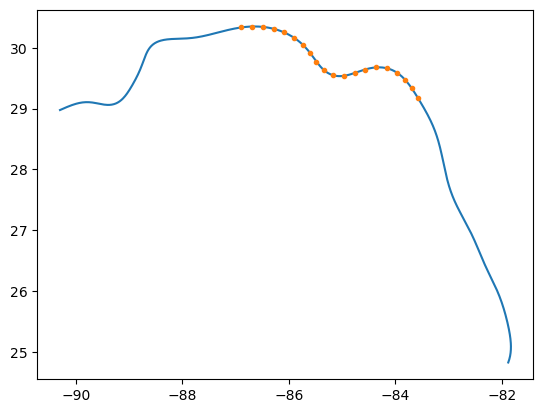

In [3]:
# Get a subset to start with
plt.plot(contour15sp[:,0], contour15sp[:,1])
s,e = 200, 400
plt.plot(contour15sp[s:e:10,0],contour15sp[s:e:10,1],'.')

In [4]:
contour_points = contour15sp[s:e:10,:]
normals = normals15sp[s:e:10,:]
print(len(contour_points))

20


In [5]:
# Read the wave model history file...this has higher density fields for depth and bulk model results
his_url = 'https://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Helene2024/rehindcast2/Output/coawst_gomsab_his.nc'
ds = xr.open_dataset(his_url)

model_lat = ds['lat_rho'].values  # Shape (512, 833)
model_lon = ds['lon_rho'].values  # Shape (512, 833)
model_h = ds['h'].values        # Shape (512, 833)
ocean_time = ds['ocean_time'].values
ntimes = len( ocean_time )
print(f'Length of ocean_time {ntimes}')
ds

Length of ocean_time 121


<xarray.Dataset> Size: 32GB
Dimensions:          (tracer: 2, s_rho: 16, s_w: 17, eta_rho: 512, xi_rho: 833,
                      eta_u: 512, xi_u: 832, eta_v: 511, xi_v: 833,
                      eta_psi: 511, xi_psi: 832, ocean_time: 121)
Coordinates:
  * s_rho            (s_rho) float64 128B -0.9688 -0.9062 ... -0.09375 -0.03125
  * s_w              (s_w) float64 136B -1.0 -0.9375 -0.875 ... -0.0625 0.0
    lon_rho          (eta_rho, xi_rho) float64 3MB -87.02 -87.01 ... -78.52
    lat_rho          (eta_rho, xi_rho) float64 3MB 20.85 20.86 ... 35.89 35.9
    lon_u            (eta_u, xi_u) float64 3MB ...
    lat_u            (eta_u, xi_u) float64 3MB ...
    lon_v            (eta_v, xi_v) float64 3MB ...
    lat_v            (eta_v, xi_v) float64 3MB ...
    lon_psi          (eta_psi, xi_psi) float64 3MB ...
    lat_psi          (eta_psi, xi_psi) float64 3MB ...
  * ocean_time       (ocean_time) datetime64[ns] 968B 2024-09-24 ... 2024-09-29
Dimensions without coordinates: tracer, eta_rho, xi_rho, eta_u, xi_u, eta_v,
                                xi_v, eta_psi, xi_psi
Data variables: (12/113)
    ntimes           int32 4B ...
    ndtfast          int32 4B ...
    dt               float64 8B ...
    dtfast           float64 8B ...
    dstart           datetime64[ns] 8B ...
    nHIS             int32 4B ...
    ...               ...
    Lwave            (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Lwavep           (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Dwave            (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Pwave_top        (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Pwave_bot        (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Uwave_rms        (ocean_time, eta_rho, xi_rho) float32 206MB ...
Attributes: (12/33)
    file:                            Output/coawst_gomsab_his.nc
    format:                          netCDF-3 64bit offset file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           COAWST ROMS SWAN
    var_info:                        varinfo.dat
    ...                              ...
    history:                         ROMS/TOMS, Version 4.1, Wednesday - Octo...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     COAWST, ANA_BSFLUX, ANA_BTFLUX, ANA_FSOB...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               16
    EXTRA_DIMENSION.boundary:        4

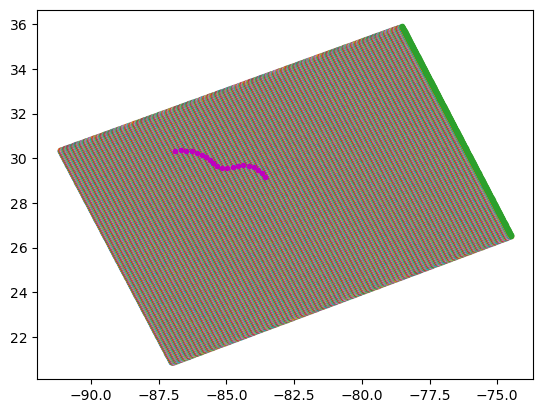

In [6]:
_= plt.plot( ds['lon_rho'], ds['lat_rho'],'.')
plt.plot( contour_points[:,0], contour_points[:,1], '.m')

In [7]:
def haversine(lon1, lat1, lon2, lat2, radius=6371.):
    """
    Calculate the great circle distance between two points
    on the earth. Input in decimal degrees.
    
    All args must be of equal length. 

    https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas   
    Default radius of earth is  6371 km
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2  
    c = 2 * np.arcsin(np.sqrt(a))
    km = radius * c
    return km


In [8]:
def haversine_ChatGPT(lon1, lat1, lon2, lat2):
    # Radius of Earth in kilometers (ChatGPT's version)
    R = 6371.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Returns distance in kilometers

In [9]:
# Bilinear interpolation function using pre-calculated distances
def bilinear_interpolation(distances, values):
    # Inverse of the distances as weights
    weights = 1 / distances
    total_weight = np.sum(weights)
    
    # Normalize the weights to sum to 1
    normalized_weights = weights / total_weight
    
    # Perform bilinear interpolation as a weighted average of the h_near values
    avg_value = np.sum(normalized_weights * values)
    
    return avg_value

In [10]:
# TODO: Speed test two Haversine routines

In [18]:
model_shape = np.shape( model_lon )
print('model shape: ', model_shape )
npoints = len( contour_points )

# Set up some arrays for output
h_avg = np.nan*np.ones( npoints )
h_min = h_avg.copy()
h_max = h_avg.copy()
Hwave_avg = np.nan*np.ones( (npoints, ntimes) )
Hwave_min = hs_avg.copy()
Hwave_max = hs_avg.copy()
Pwave_avg = hs_avg.copy()
Pwave_min = hs_avg.copy()
Pwave_max = hs_avg.copy()
Dwave_avg = hs_avg.copy()
Dwave_min = hs_avg.copy()
Dwave_max = hs_avg.copy()
Wfmag_avg = hs_avg.copy()
Wfmag_min = hs_avg.copy()
Wfmag_max = hs_avg.copy()
Wfdir_avg = hs_avg.copy()
Wfdir_min = hs_avg.copy()
Wfdir_max = hs_avg.copy()
Wfu_avg = hs_avg.copy()
Wfv_avg = hs_avg.copy()

print(np.shape(hs_avg))

# Iterate over each contour point
for i, contour_point in enumerate( contour_points):
    clon, clat = contour_point
    print(f'Contour point: {clon}, {clat}')

    # Calculate distances from the contour point to each model grid point
    distances = haversine(clon, clat, np.ravel(model_lon), np.ravel(model_lat))  # Flatten the model grid
    #print(f'Distances: {distances[:10]}')  # Print the first 10 distances for checking

    # Get the indices of the four closest points
    near_dists_flat_idx = np.argsort(distances)[:4]  # Sort distances and get the 4 smallest indices
    #print(f'Nearest 4 indices: {near_dists_flat_idx}')

    # Convert the flat indices into 2D indices
    near_idx = np.unravel_index(near_dists_flat_idx, model_shape)  # Get the 2D indices
    #print(f'2D indices of nearest points: {near_idx}')
    
    # Get the corresponding model values at those indices
    lat_near = model_lat[near_idx]
    lon_near = model_lon[near_idx]
    h_near = model_h[near_idx]

    h_avg[i] = bilinear_interpolation(distances[near_dists_flat_idx], h_near)
    h_min[i] = np.min( h_near )
    h_max[i] = np.max( h_near )
    
    print(f'Nearest Latitudes: {lat_near}')
    print(f'Nearest Longitudes: {lon_near}')
    print(f'Nearest Heights: {h_near}')
    print(f'Interpolated h: {h_avg[i]}')
    print(" ")

    for j, t in enumerate( ocean_time ):
        Hwave_near = np.array([ds['Hwave'][j, lon_idx, lat_idx].values for lon_idx, lat_idx in zip(near_idx[0], near_idx[1])])
        Dwave_near = np.array([ds['Dwave'][j, lon_idx, lat_idx].values for lon_idx, lat_idx in zip(near_idx[0], near_idx[1])])
        Pwave_near = np.array([ds['Pwave_top'][j, lon_idx, lat_idx].values for lon_idx, lat_idx in zip(near_idx[0], near_idx[1])])
        
        # Apply bilinear interpolation for Hwave, Dwave, and Pwave_top
        Hwave_avg[i, j] = bilinear_interpolation(distances[near_dists_flat_idx], Hwave_near)
        Dwave_avg[i, j] = bilinear_interpolation(distances[near_dists_flat_idx], Dwave_near)
        Pwave_avg[i, j] = bilinear_interpolation(distances[near_dists_flat_idx], Pwave_near)
        
        # Calculate the min and max values of the nearest points for Hwave, Dwave, and Pwave_top
        Hwave_min[i, j] = np.min(Hwave_near)
        Hwave_max[i, j] = np.max(Hwave_near)

        Dwave_min[i, j] = np.min(Dwave_near)
        Dwave_max[i, j] = np.max(Dwave_near)

        Pwave_min[i, j] = np.min(Pwave_near)
        Pwave_max[i, j] = np.max(Pwave_near)



model shape:  (512, 833)
(20, 121)
Contour point: -86.89903736898582, 30.33290214258056
Nearest Latitudes: [30.34155997 30.3348646  30.32304845 30.31635277]
Nearest Longitudes: [-86.89516741 -86.91032159 -86.88715738 -86.90231133]
Nearest Heights: [16.44887217 17.19059913 19.82732292 20.56910745]
Interpolated h: 18.097240454537392
 
Contour point: -86.69245096501936, 30.34887322309252
Nearest Latitudes: [30.34117622 30.34787279 30.35968444 30.36638071]
Nearest Longitudes: [-86.69644145 -86.6812882  -86.70444894 -86.68929545]
Nearest Heights: [18.83040383 18.23080684 15.5413969  14.94185666]
Interpolated h: 17.378315685349996
 
Contour point: -86.48515999192183, 30.342425864229163
Nearest Latitudes: [30.3475167  30.34081892 30.32901209 30.35421448]
Nearest Longitudes: [-86.48258352 -86.49773585 -86.47457881 -86.46743119]
Nearest Heights: [16.72030134 17.5919402  19.3624107  15.10604809]
Interpolated h: 17.132945899844916
 
Contour point: -86.28109743503859, 30.31029406778197
Nearest Lat

(20, 121)


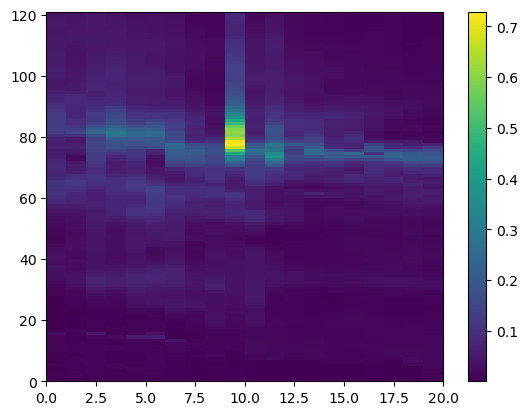

In [27]:
print(np.shape(Hwave_avg))
_ = plt.pcolormesh( (Hwave_max[:,:]-Hwave_min[:,]).T)
plt.colorbar()